<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

# Density Estimation: Gaussian Mixture Models

Clustering and density estimation technique

Approximate density using linear combination of Gaussians with different weights, means, and covariances

Seems very similar to KDE esimation where each point is a Gaussian and each Gaussian is linearly combined

Expectation maximization method like Kmeans, using posterior probability to calculate weighted mean and covariance

BIC and AIC don't take std of model or points into account

Here we'll explore **Gaussian Mixture Models**, which is an unsupervised clustering & density estimation technique.

We'll start with our standard set of initial imports

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import trapezoid

plt.style.use('seaborn-v0_8')

## Introducing Gaussian Mixture Models

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.

For example, imagine we have some one-dimensional data in a particular distribution:

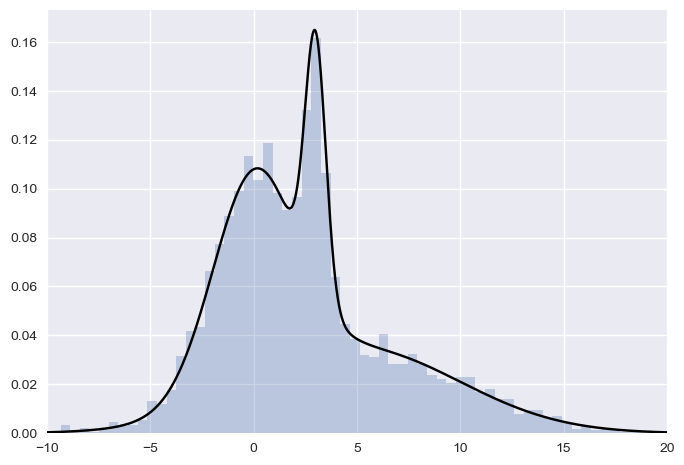

In [3]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, density='True', alpha=0.3)
plt.xlim(-10, 20)

z = np.linspace(-10,20,10000)
rv1 = stats.norm.pdf(z, 0, 2) * 20/46
rv2 = stats.norm.pdf(z, 5, 5) * 20/46
rv3 = stats.norm.pdf(z, 3, 0.5) * 6/46

rv = rv1 + rv2 + rv3
rv = rv/trapezoid(rv, x=z)

plt.plot(z, rv, 'k')
# Creating combination of Gaussians as pseudo distribution for some data.

Gaussian mixture models will allow us to approximate this density:

In [4]:
from sklearn.mixture import GaussianMixture as GMM
X = x[:, np.newaxis]
# Make X 2 dimensional
clf = GMM(4, max_iter=10000, covariance_type = 'full', random_state = 3, verbose=2,verbose_interval=1).fit(X)
# Fit GMM with 4 components

Initialization 0
  Iteration 1	 time lapse 0.28992s	 ll change inf
  Iteration 2	 time lapse 0.00452s	 ll change 0.03777
  Iteration 3	 time lapse 0.00000s	 ll change 0.01463
  Iteration 4	 time lapse 0.00000s	 ll change 0.00813
  Iteration 5	 time lapse 0.00000s	 ll change 0.00531
  Iteration 6	 time lapse 0.00801s	 ll change 0.00382
  Iteration 7	 time lapse 0.00000s	 ll change 0.00294
  Iteration 8	 time lapse 0.00000s	 ll change 0.00237
  Iteration 9	 time lapse 0.00000s	 ll change 0.00198
  Iteration 10	 time lapse 0.00000s	 ll change 0.00169
  Iteration 11	 time lapse 0.00843s	 ll change 0.00147
  Iteration 12	 time lapse 0.00000s	 ll change 0.00129
  Iteration 13	 time lapse 0.00000s	 ll change 0.00114
  Iteration 14	 time lapse 0.00000s	 ll change 0.00100
  Iteration 15	 time lapse 0.00800s	 ll change 0.00089
Initialization converged: True	 time lapse 0.31888s	 ll -2.79779


In [5]:
xpdf = np.linspace(-10, 20, 1000)
density = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])
# Get density from GMM over xpdf

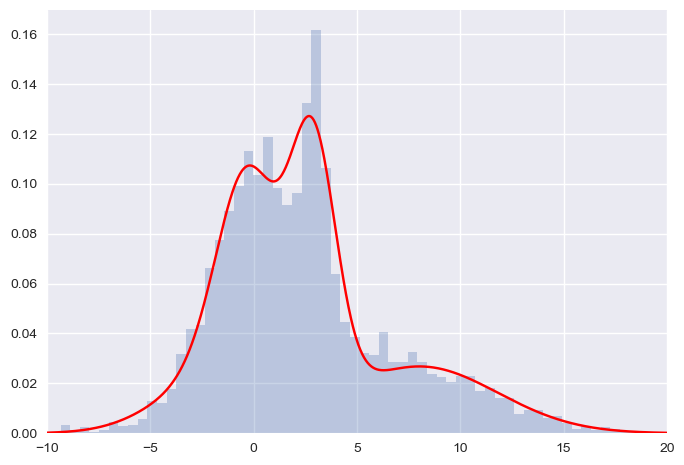

In [6]:
plt.hist(x, 80, density=True, alpha=0.3)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [7]:
clf.means_

array([[ 8.04894855],
       [-0.26509542],
       [ 2.87628921],
       [-1.762037  ]])

In [8]:
clf.covariances_

array([[[14.2611261 ]],

       [[ 2.1852085 ]],

       [[ 1.25253655]],

       [[ 7.39304484]]])

In [9]:
clf.weights_

array([0.2532411 , 0.31029078, 0.28492403, 0.15154409])

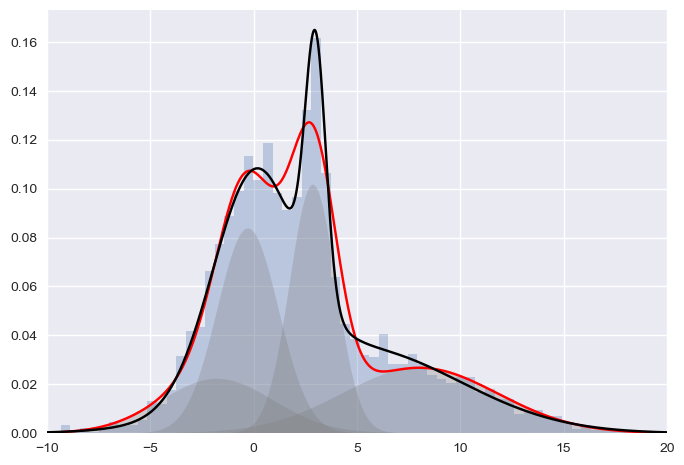

In [10]:
plt.hist(x, 80, alpha=0.3, density='True')
plt.plot(xpdf, density, '-r')
plt.plot(z, rv, 'k')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## GMM Algorithm

### Estimation Step:
- In the estimation step, we first initialize our model parameters like the mean (μk​), covariance matrix (Σk​), and mixing coefficients (πk​).
- For each data point, We calculate the posterior probabilities of data points belonging to each centroid using the current parameter values. These probabilities are often represented by the latent variables γk​.
- At the end Estimate the values of the latent variables  γ k ​ based on the current parameter values

### Maximization Step (M-step):
- In the maximization step, we update parameter values ( i.e. \mu_k , \Sigma_k and\pi_k ) using the estimated latent variable γk. 
- We will update the mean of the cluster point (μk​) by taking the weighted average of data points using the corresponding latent variable probabilities
- We will update the covariance matrix (Σk​) by taking the weighted average of the squared differences between the data points and the mean, using the corresponding latent variable probabilities.
- We will update the mixing coefficients (πk​) by taking the average of the latent variable probabilities for each component.

### Repeat the E-step and M-step until convergence
- We iterate between the estimation step and maximization step until the change in the log-likelihood or the parameters falls below a predefined threshold or until a maximum number of iterations is reached.
- Basically, in the estimation step, we update the latent variables based on the current parameter values.
- However, in the maximization step, we update the parameter values using the estimated latent variables
- This process is iteratively repeated until our model converges. 

![Gaussian Mixture Model EM Iterative Method](https://d18l82el6cdm1i.cloudfront.net/uploads/ek1bu6ogj2-em_clustering_of_old_faithful_data.gif)

## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

In [11]:
print(clf.bic(X))
print(clf.aic(X))

25825.2019102245
25754.42998281725


Let's take a look at these as a function of the number of gaussians:

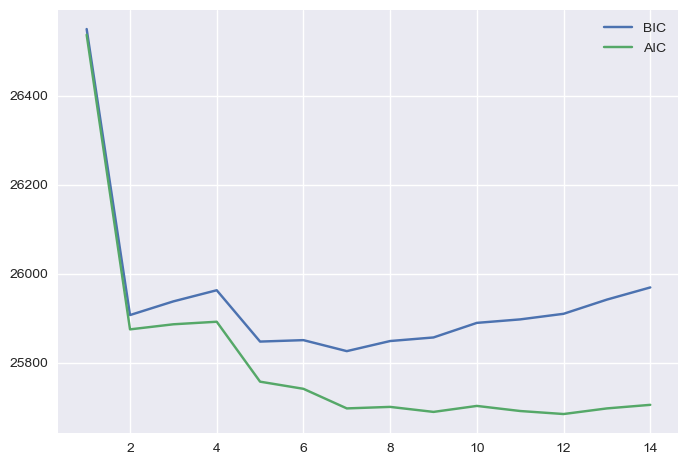

In [12]:
n_estimators = np.arange(1, 15)
clfs = [GMM(n, max_iter=10000, random_state = 1).fit(X) for n in n_estimators]
bics = [clfa.bic(X) for clfa in clfs]
aics = [clfa.aic(X) for clfa in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

It appears that for both the AIC and BIC, ~~4 (why?)~~ 7 components are preferred.

### Notice the important point: this choice of number of components measures how well GMM works as a density estimator, not how well it works as a clustering algorithm.

## Example: GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.
One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [13]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

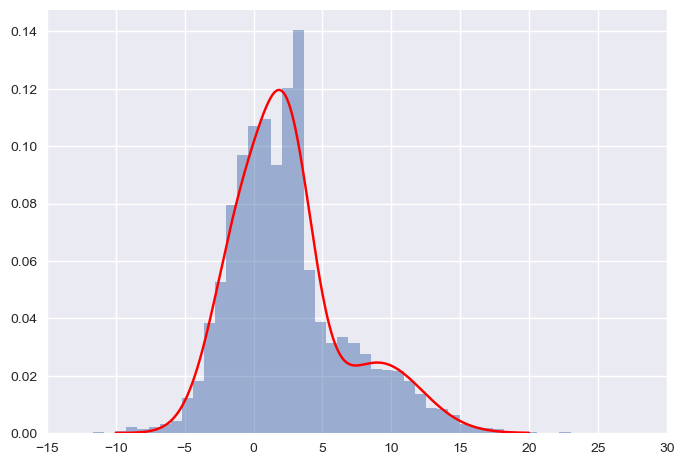

In [14]:
clf = GMM(4, max_iter=500, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])

plt.hist(y, 200, density='True', alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-15, 30);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

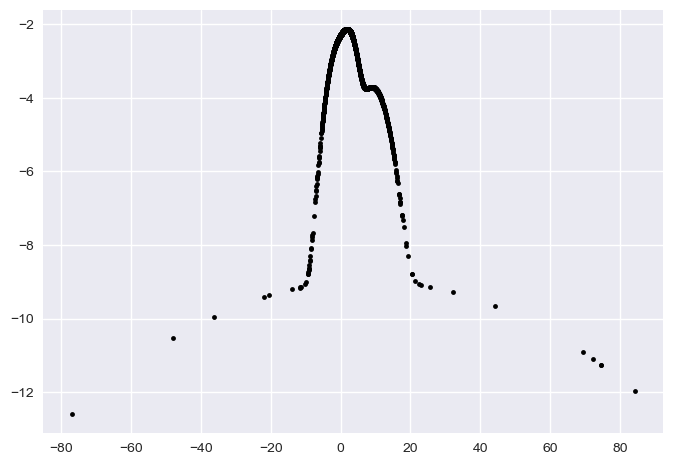

In [15]:
log_likelihood = np.array([clf.score_samples([[yy]]) for yy in y])
# log_likelihood = clf.score_samples(y[:, np.newaxis])[0]
plt.plot(y, log_likelihood, '.k');

In [16]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2130 2135 2163 2222 2496 2724 2732 2893 2897
 3067 3173 3253 3468 3483 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [17]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers:

In [18]:
set(detected_outliers) - set(true_outliers)

{2130, 2724, 3067, 3173, 3253, 3483}

Finally, we should note that although all of the above is done in one dimension, GMM does generalize to multiple dimensions, as we'll see in the breakout session.

## Other Density Estimators

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of *every* training point!

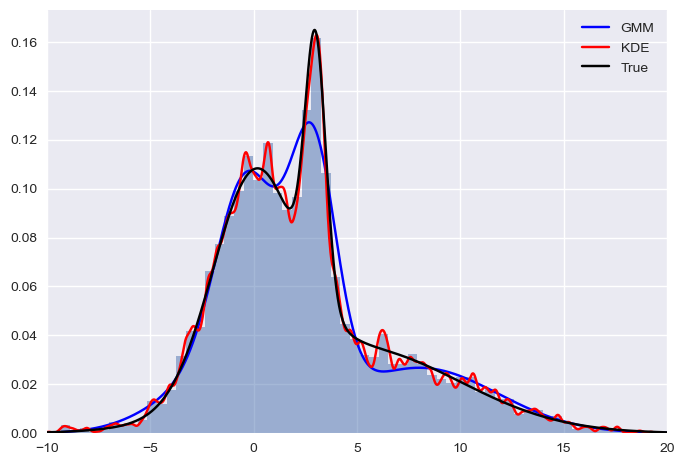

In [22]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.plot(z, rv, 'k', label='True')

plt.xlim(-10, 20)
plt.legend();

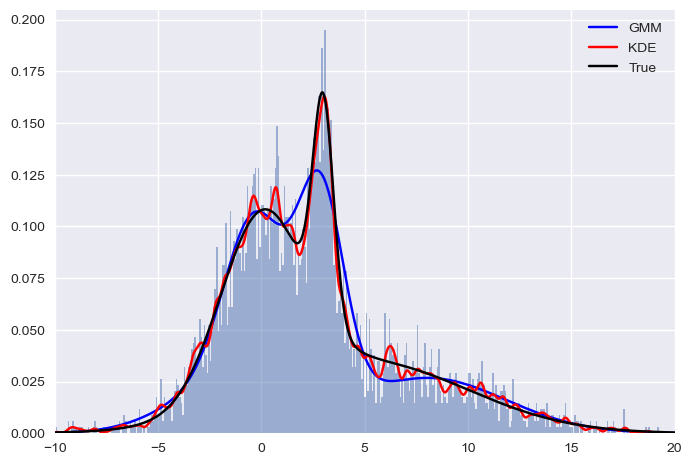

In [23]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 500, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.plot(z, rv, 'k', label='True')
plt.xlim(-10, 20)
plt.legend();

All of these density estimators can be viewed as **Generative models** of the data: that is, that is, the model tells us how more data can be created which fits the model.

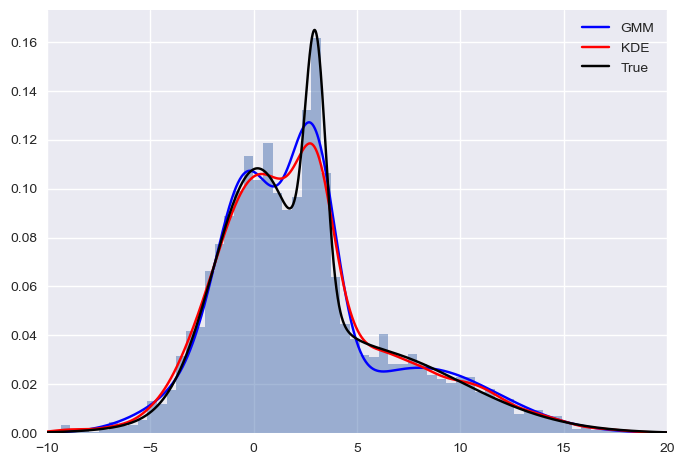

In [24]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.plot(z, rv, 'k', label='True')
plt.xlim(-10, 20)
plt.legend();